In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

## Game  by game home team or visiter team win 

In [2]:
mainData = pd.read_csv(
    os.path.join("game_logs.csv"),
    nrows=40000 # just taking the first 10k rows for efficiency
)

C:\Users\amjad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,14,19,20,81,83,93,94,95,96,97,98,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [100]:
df = mainData[['date', 'day_of_week','v_game_number','h_game_number', 'v_score','h_score','length_outs','day_night',
'attendance','length_minutes']].copy()

In [34]:
df.head()

,date,day_of_week,v_game_number,h_game_number,v_score,h_score,length_outs,day_night,attendance,length_minutes
0,18710504,5,1,1,0,2,54.0,D,200.0,120.0
1,18710505,6,1,1,20,18,54.0,D,5000.0,145.0
2,18710506,7,2,1,12,4,54.0,D,1000.0,140.0
3,18710508,2,3,1,12,14,54.0,D,5000.0,150.0
4,18710509,3,2,1,9,5,54.0,D,3250.0,145.0


In [35]:
df.shape

(40000, 10)

In [105]:
df.dtypes

date                int64
day_of_week         int64
v_game_number       int64
h_game_number       int64
v_score             int64
h_score             int64
length_outs       float64
day_night         float64
attendance        float64
length_minutes    float64
dtype: object

In [37]:
df = df.replace([' ','NULL','na','(none)'],np.nan)

In [102]:
# change date into datetime
# doing this step create a problem that it makes the data not fitted for the transformer! it make it 3d
#df['date'] = datetime.strptime('18710504', '%Y%m%d')
df['day_night'] = df['day_night'].astype('category')
df['day_night'].replace({'D':1, 'N':0}, inplace=True)

In [39]:
# calculate which column is greater than the other then if the visiting team win v=1, if the home team win h=0
df['vist_win'] = np.where(
    df['v_score'] >  df['h_score'], 1, 0)

In [40]:
print(df.isin(['NaN']).mean())

date              0.0
day_of_week       0.0
v_game_number     0.0
h_game_number     0.0
v_score           0.0
h_score           0.0
length_outs       0.0
day_night         0.0
attendance        0.0
length_minutes    0.0
vist_win          0.0
dtype: float64


In [103]:
# drop any NaNs
df_2 = df.dropna()

In [104]:
df_2.head()

,date,day_of_week,v_game_number,h_game_number,v_score,h_score,length_outs,day_night,attendance,length_minutes
0,18710504,5,1,1,0,2,54.0,1.0,200.0,120.0
1,18710505,6,1,1,20,18,54.0,1.0,5000.0,145.0
2,18710506,7,2,1,12,4,54.0,1.0,1000.0,140.0
3,18710508,2,3,1,12,14,54.0,1.0,5000.0,150.0
4,18710509,3,2,1,9,5,54.0,1.0,3250.0,145.0


## Modeling

In [43]:
#transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, KBinsDiscretizer

In [44]:
#ML model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [95]:
features = [
    'date', 'day_of_week','v_game_number','h_game_number','length_outs','day_night',
    'attendance','length_minutes'
]

target = df_2['vist_win']

In [96]:
X = df_2[features]
y = Binarizer(threshold=0.0).fit_transform([target])[0]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

In [70]:
X.shape

(4258, 8)

In [71]:
y.shape

(4258,)

In [49]:
#functions that make days as sycle 

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [88]:

extraction = ColumnTransformer([
     ('deptc', OneHotEncoder(), ['day_night']),
     ('date', FeatureUnion([
        ('doy_cos', cos_transformer(365)),
        ('doy_sin', sin_transformer(365)),
    ]), ['date']),
    ('day_of_week', FeatureUnion([
        ('dow_cos', cos_transformer(7)),
        ('dow_sin', sin_transformer(7)),
    ]), ['day_of_week']),
], remainder='passthrough')


In [113]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', GaussianNB()),
])
cross_validate(model1, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')


{'fit_time': array([0.01790118, 0.01499844, 0.00999999, 0.01606059, 0.01101255]),
 'score_time': array([0.00943208, 0.0059998 , 0.00600195, 0.0069921 , 0.00798178]),
 'test_score': array([0.6172906 , 0.57028575, 0.55973505, 0.52372067, 0.50587789])}

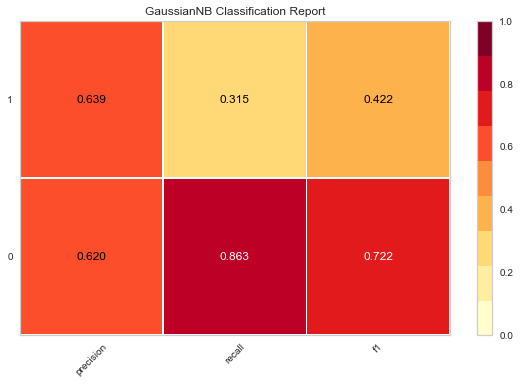

ClassificationReport(ax=<AxesSubplot:title={'center':'GaussianNB Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001B313C28E50>,
                     estimator=Pipeline(steps=[('fe',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('deptc',
                                                                                 OneHotEncoder(),
                                                                                 ['day_night']),
                                                                                ('date',
                                                                                 FeatureUnion(transformer_list=[('doy_cos',
                                                                                                                 FunctionTransforme...
                                        

In [114]:
classification_report(model1, X_train, y_train, X_test, y_test, is_fitted=False)

In [108]:
model2 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', SVC(kernel='rbf', degree=3)),
])
cross_validate(model2, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.03228903, 0.06907845, 0.13573694, 0.24899173, 0.38251758]),
 'score_time': array([0.03099918, 0.11595273, 0.08700848, 0.1140132 , 0.14604712]),
 'test_score': array([0.35051546, 0.35859729, 0.35568182, 0.35932203, 0.34827586])}

C:\Users\amjad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


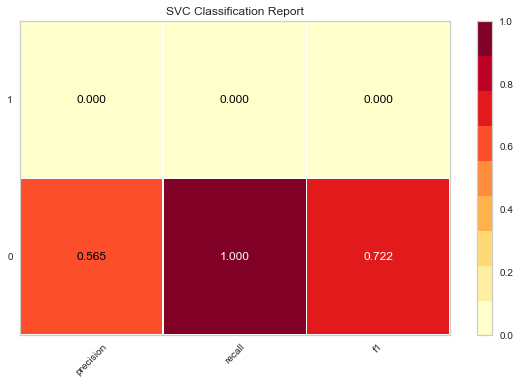

ClassificationReport(ax=<AxesSubplot:title={'center':'SVC Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001B3135A7CD0>,
                     estimator=Pipeline(steps=[('fe',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('deptc',
                                                                                 OneHotEncoder(),
                                                                                 ['day_night']),
                                                                                ('date',
                                                                                 FeatureUnion(transformer_list=[('doy_cos',
                                                                                                                 FunctionTransformer(func=...
                                        

In [110]:
classification_report(model2, X_train, y_train, X_test, y_test, is_fitted=False)

In [74]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', KNeighborsClassifier(n_neighbors=5)),
])
cross_validate(model1, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.0306437 , 0.02499843, 0.02603817, 0.0339992 , 0.03593421]),
 'score_time': array([0.049999  , 0.0470674 , 0.04695964, 0.04606271, 0.04700065]),
 'test_score': array([0.50067729, 0.55391984, 0.52162258, 0.53016922, 0.51656088])}

In [75]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', LogisticRegression()),
])
cross_validate(model1, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

C:\Users\amjad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'fit_time': array([0.04242635, 0.1490891 , 0.07004499, 0.06098962, 0.12322235]),
 'score_time': array([0.01305437, 0.01399899, 0.0129993 , 0.01500154, 0.01305795]),
 'test_score': array([0.51398284, 0.4627907 , 0.47314234, 0.38189305, 0.4099095 ])}

In [76]:
from yellowbrick.classifier import classification_report, confusion_matrix, discrimination_threshold

In [77]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', GaussianNB()),
])

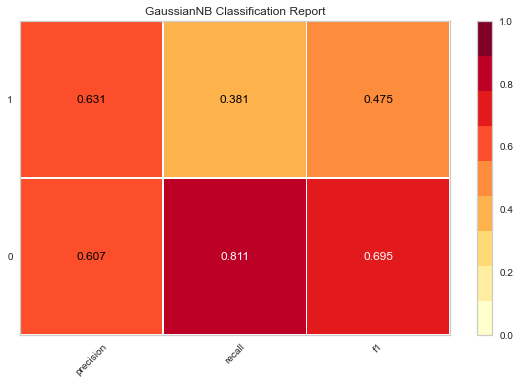

ClassificationReport(ax=<AxesSubplot:title={'center':'GaussianNB Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001B31354ABE0>,
                     estimator=Pipeline(steps=[('fe',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('deptc',
                                                                                 OneHotEncoder(),
                                                                                 ['day_night']),
                                                                                ('date',
                                                                                 FeatureUnion(transformer_list=[('doy_cos',
                                                                                                                 FunctionTransforme...
                                        

In [78]:
classification_report(model1, X_train, y_train, X_test, y_test, is_fitted=False)

In [57]:
# another way for ML modeling
# Encode the non-numeric columns
#X = OrdinalEncoder().fit_transform(features)
#y = LabelEncoder().fit_transform(target)
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC


# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Specify the classes of the target
classes = ["unoccupied", "occupied"]

visualizer = ROCAUC(
    RidgeClassifier(), classes=classes, size=(1080, 720)
)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

C:\Users\amjad\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

<Figure size 1080x720 with 0 Axes>

ValueError: could not convert string to float: 'D'

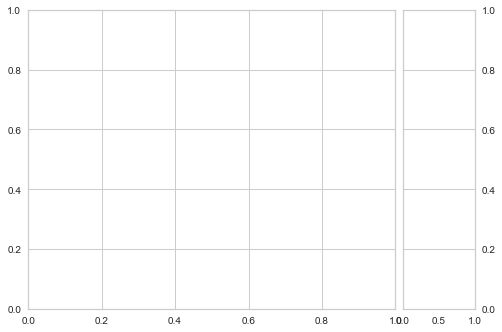

In [66]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

#transform day_night into onehoteincoder transformer

regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X, y)
    visualizer.score(X_test, y_test)
    visualizer.show()